In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# Input data files are available in the "../input/" directory.
# Any results you write to the current directory are saved as output.
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
# Imports

import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [3]:
# Input loading

labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)

train = get_training_data('../chest_xray/train')
test = get_training_data('../chest_xray/test')
val = get_training_data('../chest_xray/val')

<AxesSubplot: ylabel='Count'>

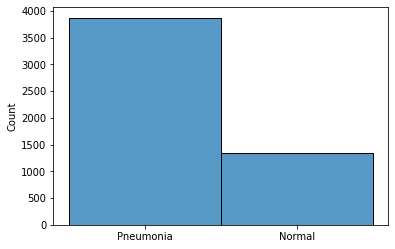

In [4]:
# Distribution plot in train set

l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
        
sns.histplot(l)

Text(0.5, 1.0, 'NORMAL')

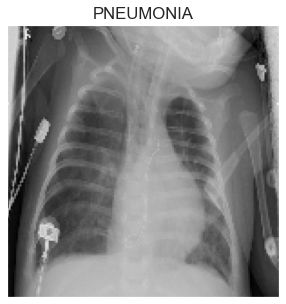

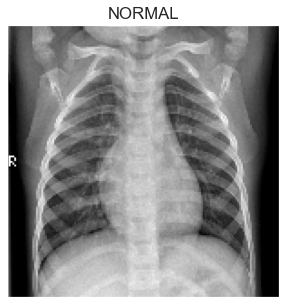

In [101]:
# Examples

plt.figure(figsize = (5,5))
plt.xticks([])
plt.yticks([])
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.xticks([])
plt.yticks([])
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [6]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [7]:
# Normalize the data

x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [8]:
# Resize data for deep learning 

x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [9]:
# Data Augmentation
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [10]:
# Training the Model

model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

In [11]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [12]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/12
163/163 [==============================] - 37s 222ms/step - loss: 0.6441 - accuracy: 0.8355 - val_loss: 8.9665 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/12
163/163 [==============================] - 36s 219ms/step - loss: 0.2857 - accuracy: 0.8993 - val_loss: 18.6231 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/12
163/163 [==============================] - ETA: 0s - loss: 0.2239 - accuracy: 0.9195
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 36s 221ms/step - loss: 0.2239 - accuracy: 0.9195 - val_loss: 27.1371 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/12
163/163 [==============================] - 36s 223ms/step - loss: 0.1600 - accuracy: 0.9459 - val_loss: 3.5019 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 5/12
163/163 [==============================] - ETA: 0s - loss: 0.1451 - accuracy: 0.9515
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 [====================

In [13]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 1s 51ms/step - loss: 0.3281 - accuracy: 0.8782
Loss of the model is -  0.32814282178878784
20/20 [==============================] - 1s 51ms/step - loss: 0.3281 - accuracy: 0.8782
Accuracy of the model is -  87.82051205635071 %


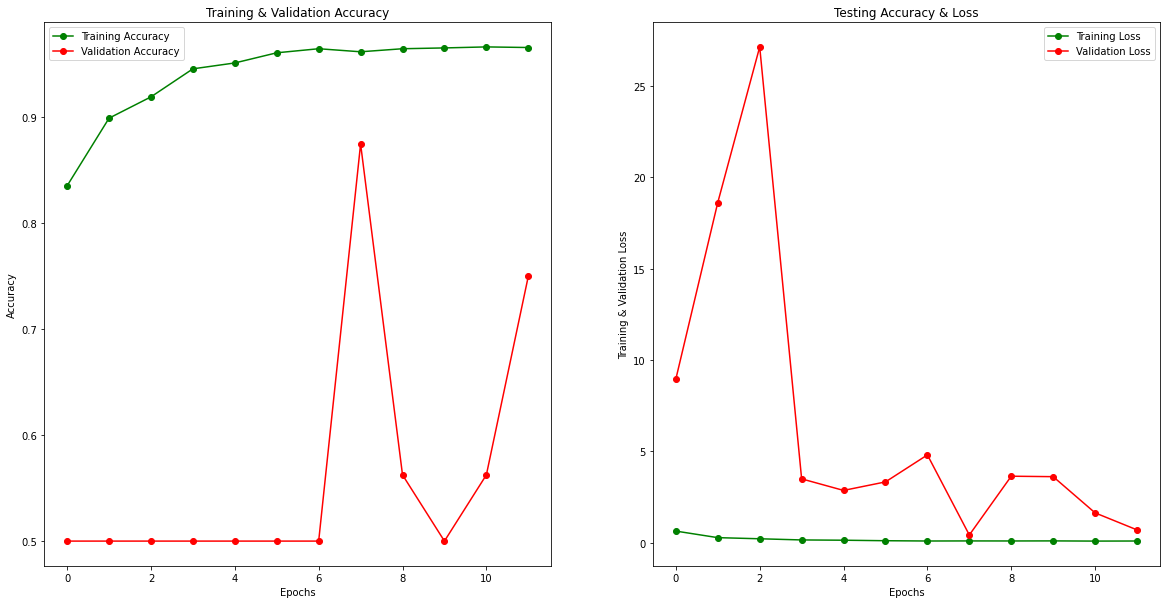

In [14]:
# Analysis after Model Training

epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [15]:
# Predictions

predictions = (model.predict(x_test) > 0.5).astype("int32")
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

array([0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [16]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.93      0.87      0.90       390
   Normal (Class 1)       0.80      0.89      0.85       234

           accuracy                           0.88       624
          macro avg       0.87      0.88      0.87       624
       weighted avg       0.88      0.88      0.88       624



In [17]:
cm = confusion_matrix(y_test,predictions)
cm

array([[339,  51],
       [ 25, 209]])

In [18]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<AxesSubplot: >

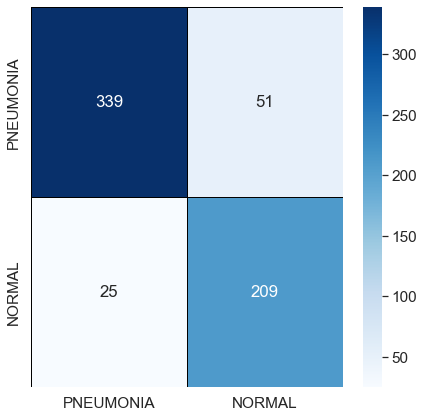

In [98]:
plt.figure(figsize = (7,7))
sns.set(font_scale=1.4)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black', linewidth = 1, annot = True, fmt='', xticklabels = labels, yticklabels = labels)

In [20]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

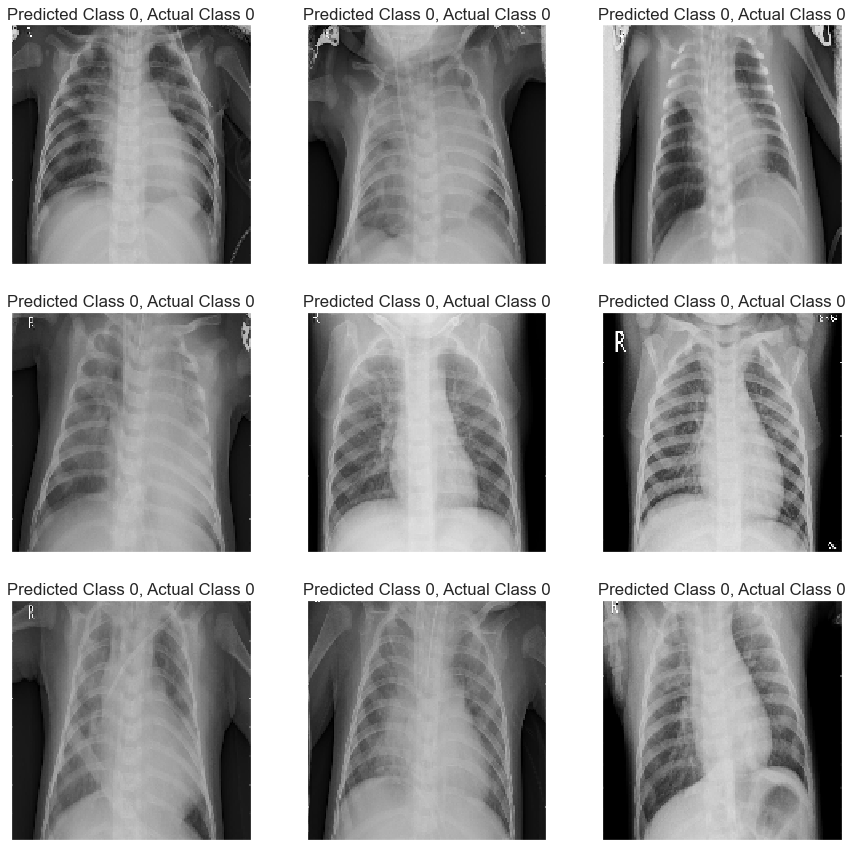

In [94]:
# Some of the Correctly Predicted Classes

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
for i in range(3):
    for j in range(3):
        axs[i, j].set_yticks([])
        axs[i, j].set_xticks([])
        axs[i, j].imshow(x_test[correct[3*i+j]].reshape(150,150), cmap="gray", interpolation='none')
        axs[i, j].set_title("Predicted Class {}, Actual Class {}".format(predictions[correct[3*i+j]], y_test[correct[3*i+j]]))

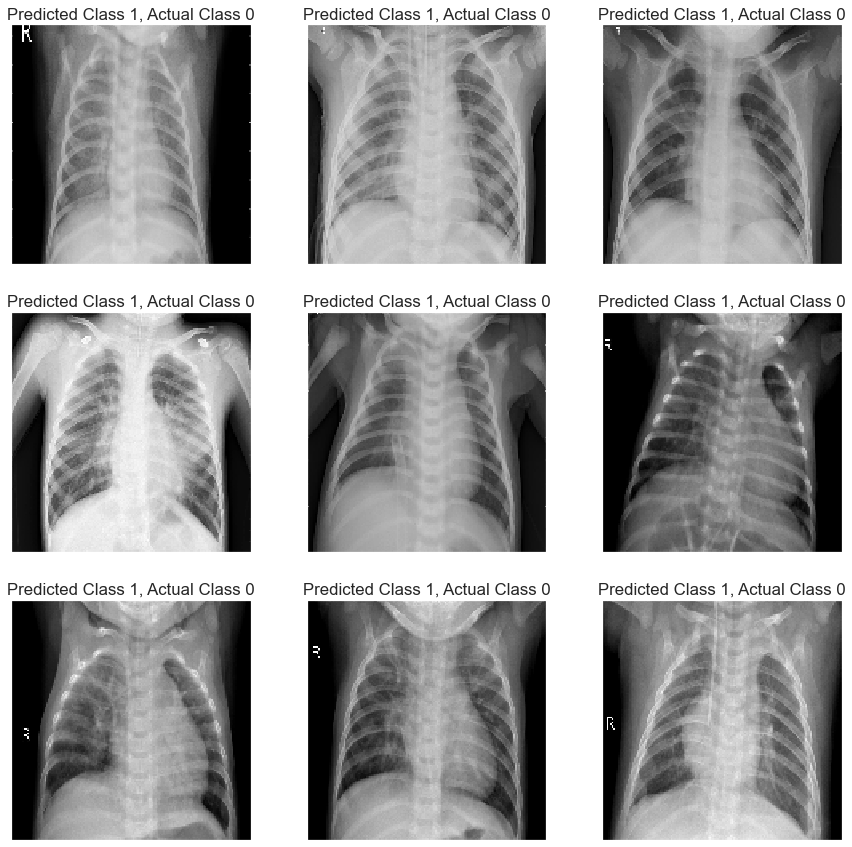

In [95]:
# Some of the Incorrectly Predicted Classes

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
for i in range(3):
    for j in range(3):
        axs[i, j].set_yticks([])
        axs[i, j].set_xticks([])
        axs[i, j].imshow(x_test[incorrect[3*i+j]].reshape(150,150), cmap="gray", interpolation='none')
        axs[i, j].set_title("Predicted Class {}, Actual Class {}".format(predictions[incorrect[3*i+j]], y_test[incorrect[3*i+j]]))